In [49]:
import numpy as np 
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [53]:
# activation functions 
class activation:
    def __init__(self):
        pass
        
    # the relu
    def relu(self, z):
        return np.maximum(0, z)

    # the derivative of relu
    def deriv_relu(self, z):
        return z > 0
            
    # the sigmoid
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
        
    # derivative of sigmoid
    def deriv_sigmoid(self, z):
        sig = self.sigmoid(z)
        return sig * (1 - sig)
          
    # the softmax
    def softmax(self, z):
        exp_values = np.exp(z - np.max(z , axis = 1 , keepdims = True))
        return exp_values / np.sum(exp_values , axis = 1 , keepdims = True)

    def tanh(self,z):
        return np.tanh(z)
    
activate = activation()

In [55]:
# layers 
class layer_dense:
    def __init__(self, n_of_input, n_of_neuron, activation=None): # give number of columns of one input as n_of_input
        self.weights = np.random.randn(n_of_input, n_of_neuron) * 0.20
        self.bias = np.random.randn(1, n_of_neuron)
        self.activation = activation
        
    def forward_prop(self, input):
        self.input = input
        self.out = np.dot(input, self.weights) + self.bias
        if self.activation:
            self.out = self.activation(self.out)
        return self.out

    def backward_prop(self, dervLoss_by_dervOut, learningrate):
        if self.activation == activate.relu:
            dervLoss_by_dervOut = dervLoss_by_dervOut * activate.deriv_relu(self.out)
        elif self.activation == activate.sigmoid:
            dervLoss_by_dervOut = dervLoss_by_dervOut * activate.deriv_sigmoid(self.out)
            
        dL_dinput = np.dot(dervLoss_by_dervOut, self.weights.T)
        dL_dweights = np.dot(self.input.T, dervLoss_by_dervOut)
        dL_dbias = np.sum(dervLoss_by_dervOut, axis=0, keepdims=True)
        
        self.weights -= learningrate * dL_dweights
        self.bias -= learningrate * dL_dbias

        return dL_dinput

In [57]:
#loss function 
class Loss:
    def __init__(self):
        pass

    def log_loss(self, predicted_y, known_y):
        predicted_y = np.clip(predicted_y, 1e-15, 1 - 1e-15)
        return -np.sum(known_y * np.log(predicted_y)) / predicted_y.shape[0]

    def derivative_log_loss(self, predicted_y, known_y):
        return (predicted_y - known_y) / predicted_y.shape[0]

losses = Loss()

In [59]:
class NeuralNetwork:
    def __init__(self):
        self.layer_holder = []

    def add_layer(self, layer):
        self.layer_holder.append(layer)

    def forward(self, X):
        for layer in self.layer_holder:
            X = layer.forward_prop(X)
        return X

    def backward(self, X, predicted_y, known_y, learningrate):
        dervLoss_by_dervOut = losses.derivative_log_loss(predicted_y, known_y)
        for layer in reversed(self.layer_holder):
            dervLoss_by_dervOut = layer.backward_prop(dervLoss_by_dervOut, learningrate)

    def train(self, X, Y, epochs, learningrate):
        for epoch in range(epochs):
            predicted_Y = self.forward(X)
            loss = losses.log_loss(predicted_y = predicted_Y, known_y = Y)
            self.backward(X, predicted_Y, Y, learningrate)
            predictions = predicted_Y 
            accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(Y, axis=1))
            print(f"epoch = {epoch}, loss = {loss}, accuracy = {accuracy}")

    def predict(self, X):
        predictions = self.forward(X)
        return predictions


In [90]:
#dataset loading and preprocessing
(x_train , y_train) , (x_test , y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = x_train.reshape(len(x_train) , 784)
x_test = x_test.reshape(len(x_test) , 784)

#y_train = to_categorical(y_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

7840000


In [84]:
nn = NeuralNetwork()
nn.add_layer(layer_dense(784, 800, activate.tanh))
nn.add_layer(layer_dense(800, 3000, activate.tanh))
nn.add_layer(layer_dense(3000, 30, activate.tanh))
nn.add_layer(layer_dense(30, 10, activate.tanh))
nn.add_layer(layer_dense(10, 10, activate.softmax))

nn.train(x_train, y_train, 10, 0.01)

# Predict on the training data
predictions = nn.predict(x_test)
print("Predictions:")
print(predictions)

epoch = 0, loss = 2.7782165262845986, accuracy = 0.10728333333333333
epoch = 1, loss = 2.634894622583961, accuracy = 0.10936666666666667
epoch = 2, loss = 2.5708261860915886, accuracy = 0.12645
epoch = 3, loss = 2.5282243609943835, accuracy = 0.13811666666666667
epoch = 4, loss = 2.502375083410796, accuracy = 0.1454
epoch = 5, loss = 2.486410538914757, accuracy = 0.15165
epoch = 6, loss = 2.475924489024254, accuracy = 0.15705
epoch = 7, loss = 2.4691167909805434, accuracy = 0.16271666666666668
epoch = 8, loss = 2.4642623973877096, accuracy = 0.16808333333333333
epoch = 9, loss = 2.460683921434794, accuracy = 0.17255
Predictions:
[[0.07267773 0.02958725 0.12124282 ... 0.32922135 0.01345164 0.13955361]
 [0.10996502 0.04365723 0.2494111  ... 0.22058544 0.01685036 0.10313953]
 [0.07708237 0.03818584 0.22219475 ... 0.2096391  0.0176792  0.12817552]
 ...
 [0.0673864  0.03006234 0.19251616 ... 0.19577373 0.02352078 0.19595683]
 [0.09383983 0.0387987  0.23306911 ... 0.20404022 0.01938197 0.127

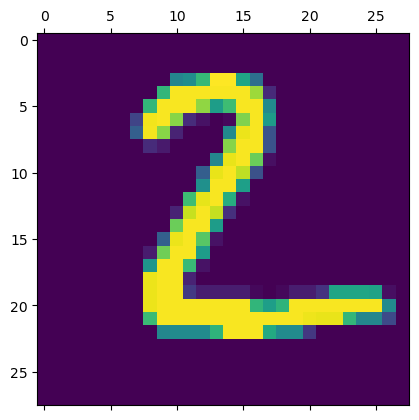

In [106]:
# to test
import matplotlib.pyplot as plt

plt.matshow(x_test[1].reshape(28,28))
plt.show()

In [108]:
print(np.argmax(predictions[1]))

2
